# BroadBand data clustering
This notebook searches for proper clustering number of (unsupervised) clustering method (K-Means, AC, etc) as for exploring posible targets recorded by broad-band sonar. 

Elbow estimation method is used.

> [Yi Liu] **Note** that the final suggested 'proper' number of cluster is not always the 'best' choice. This is for how the elbow curve acquired and what it means.   
I. One equation:  
\begin{equation}
D = \sum_{N_c} F_c(\mathbf{X_c})
\end{equation}
$\ \ \ \ where\ \mathbf{X} \in \mathcal{R}_N^d is\ of\ N\ samples\ across\ d\ dimension,\ c\in\{1,2,\cdots,K\}\ represents\ K\ cluster\ index. F\ is\ a\ function\ calculating\ a\ clusters\ properties\ such\ as\ stanrard\ variation.$  
II. Two extremes: 1) (normally,) a data set has the largest variation as one whole cluster vs 2) the sum variation is zero when each sample is a cluster. So from 1 cluster to Ns (number of samples), it comes with a falling curve.  
IIi. An "L" shape curve is often observed in practices, where the turning piont means that increasing the number won't introduce significant reduction of clusters' standard variations.  
Therefore, a value around the `turning point` is often chosen according to domain expertise and specific demands.


In [1]:
import os
print(os.getcwd())

import pandas as pd
import numpy as np
import seaborn as sns
import sklearn.cluster as cluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import time
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from colorama import Fore    


# try: from sklearn.manifold import TSNE; HAS_SK=True
# except: HAS_SK=False; print('Please install sklearn for layer visualization')

/Users/yi.liu/Dropbox/Work@IMR/Clustering-Braodband-master/Old and Backup


In [2]:
filepaths = ["/mnt/d/Data/broadband sonar/",         # ASUS subsystem
             "/home/deep/deep/data/broadband",       # pallas/styx servers
             "/home/personal/data/Mette_Agersted",   # thinkpad
             "/Users/yi.liu/OneDrive - Itera/Data",  # macbook
             "gdrive/My Drive/Data",                 # google drive
            ]
# print("Files in the data folder: \n", os.listdir(filepath))

filename = "TS_MESSOR_AllStations.csv"  #  "TS_st.127.csv" #  # "TS_MESSOR_AllStations.csv"

for fp in filepaths:
    if  os.path.exists(os.path.join(fp, filename)):
        print("\nData found at : %s. Reading ..." % fp)
        f = pd.read_csv(os.path.join(fp, filename), header=0)
    else:
        print("File not existing in %s, please check." % fp)

        # with  pd.read_csv(os.path.join(filepath, filename), header=0) as f:
# pd.read_csv(os.path.join(filepath, filename), header=0)

File not existing in /mnt/d/Data/broadband sonar/, please check.
File not existing in /home/deep/deep/data/broadband, please check.
File not existing in /home/personal/data/Mette_Agersted, please check.

Data found at : /Users/yi.liu/OneDrive - Itera/Data. Reading ...
File not existing in gdrive/My Drive/Data, please check.


In [3]:
print("before cleaning")
display(f.head(3))
display(f.tail(3))

before cleaning


,Unnamed: 0,Date,PingNo,Range,Alo,Ath,F_52000,F_53000,F_54000,F_55000,...,F_70000,F_71000,F_72000,F_73000,F_74000,F_75000,F_76000,F_77000,F_78000,Depth
0,48557,2019-05-03 21:00:00.089,13695.0,15.563,0.75,2.24,-59.47,-59.60,-60.95,-60.16,...,-53.88,-54.32,-54.95,-55.39,-55.82,-56.45,-56.85,-57.61,-58.04,829.116354
1,48558,2019-05-03 21:00:00.089,13695.0,24.695,0.64,1.45,-60.84,-66.91,-67.26,-67.67,...,-55.11,-54.10,-53.81,-53.11,-52.85,-52.63,-52.53,-52.74,-52.87,829.116354
2,48559,2019-05-03 21:00:00.339,13696.0,11.687,2.61,0.64,-62.16,-54.61,-59.02,-57.96,...,-57.48,-57.81,-57.74,-58.17,-58.16,-58.92,-59.12,-60.33,-61.26,829.068901


,Unnamed: 0,Date,PingNo,Range,Alo,Ath,F_52000,F_53000,F_54000,F_55000,...,F_70000,F_71000,F_72000,F_73000,F_74000,F_75000,F_76000,F_77000,F_78000,Depth
4380443,19312511,2019-05-22 06:33:46.178,53978.0,35.649,2.71,0.96,-72.80,-72.99,-74.39,-73.79,...,-68.79,-68.91,-69.12,-69.35,-69.50,-69.92,-70.03,-70.54,-71.03,9.489469
4380444,19312611,2019-05-22 06:33:46.178,53978.0,38.498,-1.87,-0.75,-71.21,-71.36,-72.54,-71.79,...,-69.31,-69.45,-69.70,-69.80,-69.80,-70.12,-70.15,-70.44,-70.64,9.489469
4380445,19312711,2019-05-22 06:33:46.178,53978.0,38.999,0.21,3.38,-73.51,-73.85,-75.18,-74.81,...,-68.43,-68.69,-69.17,-69.55,-69.95,-70.56,-71.04,-71.73,-72.32,9.489469


In [4]:
f.describe()

,Unnamed: 0,PingNo,Range,Alo,Ath,F_52000,F_53000,F_54000,F_55000,F_56000,...,F_70000,F_71000,F_72000,F_73000,F_74000,F_75000,F_76000,F_77000,F_78000,Depth
count,4.380446e+06,4.380446e+06,4.380446e+06,4.380446e+06,4.380446e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,...,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.360626e+06,4.380446e+06
mean,4.142936e+06,2.851600e+04,2.743341e+01,-5.381058e-02,5.647198e-02,-6.335314e+01,-6.264839e+01,-6.446078e+01,-6.406489e+01,-6.353153e+01,...,-6.346098e+01,-6.338689e+01,-6.373116e+01,-6.381342e+01,-6.396924e+01,-6.413254e+01,-6.429296e+01,-6.449881e+01,-6.495664e+01,4.546448e+02
std,5.337844e+06,1.969330e+04,1.000483e+01,1.636214e+00,1.630147e+00,8.490364e+00,9.859577e+00,9.303255e+00,9.635745e+00,9.379546e+00,...,9.249796e+00,8.775063e+00,9.550103e+00,9.329257e+00,9.628827e+00,9.421894e+00,9.528505e+00,9.817972e+00,9.619486e+00,2.473432e+02
min,7.339000e+03,1.000000e+01,0.000000e+00,-3.450000e+00,-3.390000e+00,-1.176700e+02,-1.183200e+02,-1.187800e+02,-1.222900e+02,-1.174000e+02,...,-1.359300e+02,-1.239900e+02,-1.334000e+02,-1.360700e+02,-1.307900e+02,-1.343700e+02,-1.326600e+02,-1.364000e+02,-1.395000e+02,3.620985e+00
25%,1.153232e+06,9.988000e+03,2.187100e+01,-1.310000e+00,-1.190000e+00,-6.700000e+01,-6.797000e+01,-6.928000e+01,-6.903000e+01,-6.827000e+01,...,-6.626000e+01,-6.613000e+01,-6.625000e+01,-6.626000e+01,-6.627000e+01,-6.644000e+01,-6.646000e+01,-6.653000e+01,-6.704000e+01,3.202746e+02
50%,2.266016e+06,3.010500e+04,2.973200e+01,-5.000000e-02,6.000000e-02,-6.032000e+01,-5.973000e+01,-6.160000e+01,-6.118000e+01,-6.063000e+01,...,-6.077000e+01,-6.082000e+01,-6.107000e+01,-6.118000e+01,-6.128000e+01,-6.147000e+01,-6.165000e+01,-6.169000e+01,-6.241000e+01,4.909251e+02
75%,3.938269e+06,4.021800e+04,3.540500e+01,1.200000e+00,1.300000e+00,-5.799000e+01,-5.593000e+01,-5.821000e+01,-5.770000e+01,-5.740000e+01,...,-5.847000e+01,-5.856000e+01,-5.881000e+01,-5.893000e+01,-5.903000e+01,-5.931000e+01,-5.944000e+01,-5.962000e+01,-6.002000e+01,6.145516e+02
max,4.117611e+07,1.019460e+05,4.014800e+01,3.460000e+00,3.510000e+00,1.760000e+01,2.446000e+01,1.738000e+01,1.570000e+01,1.622000e+01,...,2.249000e+01,2.257000e+01,2.211000e+01,2.198000e+01,2.213000e+01,2.179000e+01,2.246000e+01,2.183000e+01,2.360000e+01,1.015681e+03


## 1 Clean the data
- remove irrelavant fields and strange frequencies (see data details)  
- remove NaN values by row (samples)   

In [5]:
# Functions to use
def get_hist(fre):
    hist, bin_edges = np.histogram(fre, bins = 100)
#     print(hist.shape, bin_edges.shape, bin_edges)
    
    f, axs = plt.subplots(1,1, figsize = (15, 5))
    axs.plot(bin_edges[:-1], hist)
    plt.xlabel('TS')
#     plt.ylabel('Number')

# get percentiles
def get_percentiles(fre):
    percentiles = np.percentile(fre, (2.5, 99))
    return percentiles

# get thresholds
def get_threshold(fre):
    hist, bin_edges = get_hist(fre)
    pass

In [6]:
## Irrelevant fields & freqs to discard
col_irrelavent = ['Unnamed: 0', 'Date', 'Range', 'PingNo', 'Alo', 'Ath', 'Depth', 'F_52000', 'F_53000']
col_relevant = ["F_"+str(v) for v in range (54000, 78001, 1000)]

# for i, c in enumerate(col_irrelavent):
#     # print(i)
#     if not type(c) is str:
#         f.drop(f.columns[c], axis=1, inplace=True)
#     else:
#         if c in f:
#             f.drop(c, axis=1, inplace=True)
            
## Remove missing values - remember the index
#  here we don't use imputation for
#  - we have really a lot of information
#  - we want to explore reflectances (so clean samples matter more)
idxNa = f.isna().any(axis=1) # any NAN existing in a row [axis=1 - column, any column entry]
f_nandropped=f.dropna(axis=0, how = 'any') # drop samples by row, where any value missing 


# Interesting * missing values showed up in a sequential series
print("In total %d NaN samples." % len(idxNa.index[idxNa==True]))
print("They tart from %d, stop at %d, which are thus sequential: %d-%d+1 = 19820" % \
      (idxNa.index[idxNa==True][0], idxNa.index[idxNa==True][-1], \
       idxNa.index[idxNa==True][-1], idxNa.index[idxNa==True][0]))

f_nan = f[col_relevant][idxNa==True]
print("some rows with Nan:")
f_nan.head()

In total 19820 NaN samples.
They tart from 779636, stop at 799455, which are thus sequential: 799455-779636+1 = 19820
some rows with Nan:


,F_54000,F_55000,F_56000,F_57000,F_58000,F_59000,F_60000,F_61000,F_62000,F_63000,...,F_69000,F_70000,F_71000,F_72000,F_73000,F_74000,F_75000,F_76000,F_77000,F_78000
779636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-61.70,-60.73,-61.12,...,-63.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-56.08,-52.43,-52.74,...,-58.78,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779638,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-70.07,-86.55,-73.10,...,-55.17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779639,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-59.24,-55.58,-55.32,...,-61.55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
779640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-57.75,-54.11,-53.70,...,-61.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
index_discarded_by_row = []

# aggregate all indices that are too weak/strong
for (colName, colData) in f_nandropped.iteritems():
    
    if not colName in col_irrelavent:
        print("Collect index of the records to drop by frequency: ", colName)
#         print(type(colName))
        # drop the records by mannual threshold (usually with wider intervals)
        # f = f.drop(f[f[colName]>=strength_thre[0]].index)
        # f = f.drop(f[f[colName]<=strength_thre[1]].index)


        # drop the records by percentiles (usually with narrower intervals)
        percentiles = get_percentiles(colData.values[:])    
    
        [index_discarded_by_row.append(ind) for ind in colData[colData<=percentiles[0]].index]
        [index_discarded_by_row.append(ind) for ind in colData[colData>=percentiles[1]].index]
        
        
#         percentiles = get_percentiles(f_nandropped[colName].values[:500000])    
    
#         [index_discarded_by_row.append(ind) for ind in f_nandropped[f_nandropped[colName]<=percentiles[0]].index]
#         [index_discarded_by_row.append(ind) for ind in f_nandropped[f_nandropped[colName]>=percentiles[1]].index]

# remove repeted indices by getting unique
ind_disc_b_r = np.array(index_discarded_by_row)
ind_disc_b_r = np.unique(ind_disc_b_r)

print("To drop %d samples of %d. " \
      % (len(ind_disc_b_r), len(f_nandropped))  )
#     f = f.drop(f[f[colName]>=percentiles[1]].index)


Collect index of the records to drop by frequency:  F_54000
Collect index of the records to drop by frequency:  F_55000
Collect index of the records to drop by frequency:  F_56000
Collect index of the records to drop by frequency:  F_57000
Collect index of the records to drop by frequency:  F_58000
Collect index of the records to drop by frequency:  F_59000
Collect index of the records to drop by frequency:  F_60000
Collect index of the records to drop by frequency:  F_61000
Collect index of the records to drop by frequency:  F_62000
Collect index of the records to drop by frequency:  F_63000
Collect index of the records to drop by frequency:  F_64000
Collect index of the records to drop by frequency:  F_65000
Collect index of the records to drop by frequency:  F_66000
Collect index of the records to drop by frequency:  F_67000
Collect index of the records to drop by frequency:  F_68000
Collect index of the records to drop by frequency:  F_69000
Collect index of the records to drop by 

In [8]:
# Selected Frequencies to use in clustering
col_relevant = ["F_"+str(v) for v in range (54000, 78001, 1000)]

f_nan_pct_dropped = f_nandropped.drop(axis=0, index=ind_disc_b_r)
data =  np.array(f_nan_pct_dropped[col_relevant].values)

print(Fore.BLUE + "--> Frequency of data: \t%s" % col_relevant, 
      Fore.CYAN + "--> Max/min of data : [%f, %f]" % (data.max(), data.min()),
      Fore.BLUE + "--> Size of data : [%d x %d]" % (data.shape),
      Fore.CYAN + "--> Statistics (1000) after cleaned:", 
      sep='\n\n')
f_nan_pct_dropped[:50000].describe()


--> Frequency of data: 	['F_54000', 'F_55000', 'F_56000', 'F_57000', 'F_58000', 'F_59000', 'F_60000', 'F_61000', 'F_62000', 'F_63000', 'F_64000', 'F_65000', 'F_66000', 'F_67000', 'F_68000', 'F_69000', 'F_70000', 'F_71000', 'F_72000', 'F_73000', 'F_74000', 'F_75000', 'F_76000', 'F_77000', 'F_78000']

--> Max/min of data : [-49.770000, -85.400000]

--> Size of data : [3872988 x 25]

--> Statistics (1000) after cleaned:


,Unnamed: 0,PingNo,Range,Alo,Ath,F_52000,F_53000,F_54000,F_55000,F_56000,...,F_70000,F_71000,F_72000,F_73000,F_74000,F_75000,F_76000,F_77000,F_78000,Depth
count,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,...,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,82124.92148,21948.945180,29.233073,0.221226,0.057083,-59.497632,-57.680690,-59.911904,-59.306728,-58.919314,...,-59.263350,-59.455315,-59.669175,-59.777942,-59.763928,-60.062751,-60.023218,-60.489837,-60.619879,614.477696
std,17158.66078,3701.135923,8.026799,1.697276,1.700751,4.032552,7.338592,6.413574,6.828538,6.487964,...,4.316827,4.084465,3.919487,3.694848,3.529939,3.361141,3.233220,3.145628,3.088475,82.365174
min,48557.00000,13695.000000,4.022000,-3.450000,-3.390000,-83.460000,-91.900000,-84.020000,-83.370000,-82.100000,...,-81.400000,-83.830000,-83.820000,-83.010000,-81.970000,-83.330000,-83.500000,-83.810000,-84.990000,499.287800
25%,68384.50000,18840.000000,24.133000,-1.100000,-1.302500,-60.170000,-59.060000,-60.850000,-60.300000,-59.810000,...,-60.370000,-60.620000,-60.750000,-60.890000,-60.790000,-61.110000,-61.040000,-61.570000,-61.730000,544.194700
50%,83240.50000,22555.500000,30.955000,0.280000,0.050000,-58.490000,-55.670000,-58.170000,-57.460000,-57.150000,...,-58.790000,-59.020000,-59.190000,-59.350000,-59.310000,-59.640000,-59.580000,-60.040000,-60.170000,602.332770
75%,96740.25000,25240.000000,35.833000,1.600000,1.410000,-57.100000,-52.920000,-55.810000,-54.950000,-54.750000,...,-56.610000,-56.950000,-57.280000,-57.510000,-57.630000,-58.040000,-58.100000,-58.610000,-58.770000,672.158251
max,110265.00000,27121.000000,39.989000,3.460000,3.510000,-49.830000,-46.480000,-51.270000,-50.310000,-50.600000,...,-52.380000,-52.480000,-52.920000,-53.050000,-53.260000,-53.650000,-53.750000,-54.200000,-54.150000,829.116354


In [9]:
data[:5,:] # check if the data is correctly obtained
# data.min()
indNan = np.isnan(data)
# [print(ind) for ind in indNan if ind is True]

data.max(axis=0), data.min(axis=0)

(array([-51.27, -50.31, -50.42, -49.77, -50.13, -50.19, -50.28, -50.78,
        -50.98, -51.17, -51.42, -51.58, -51.74, -52.16, -52.15, -52.41,
        -52.38, -52.48, -52.86, -53.05, -53.23, -53.65, -53.75, -54.2 ,
        -54.14]),
 array([-84.07, -83.38, -82.31, -81.43, -81.41, -81.  , -80.61, -80.94,
        -81.3 , -81.66, -83.81, -85.05, -84.49, -85.04, -84.56, -84.7 ,
        -84.25, -83.94, -83.97, -83.24, -83.95, -84.07, -84.22, -84.21,
        -85.4 ]))

## 2. Clustering and elbow visualization

Prepare the data. Normalizing won't make big difference regarding the shape of the elbow curve in this case.

In [10]:
data2 = data.copy()
col_mean = data2.mean(axis = 0)
# data2 = data2 - col_mean[np.newaxis, :]
data2 = (data2 - data2.min())/(data2.max()-data2.min()) 
plot_only=1000000
ind_only = np.random.permutation(data2.shape[0])
ind_only = ind_only[:plot_only]
pca = PCA(n_components=13)
pca.fit(data2[ind_only,:])
low_dim_embs = pca.transform(data2)
# print(data[5,0], data2[5,0],col_mean[0])

Observations:
- The `L` shape turning is not `sharp` enough like typically L, meaning that the targets are highly similar and we need more domain expertise input.
- Increasing the value of maximum clustering number leads to larger `L` turning point. Still, values around 20 are recommended.
- To see an `L` shape, the maximum clustering number value can be adjusted larger when needed.
- As for the selection of final clustering number, larger value (than the `L` value) is recommended for the purpose of exploring as many as possible targets.

**K-means** elbow curve

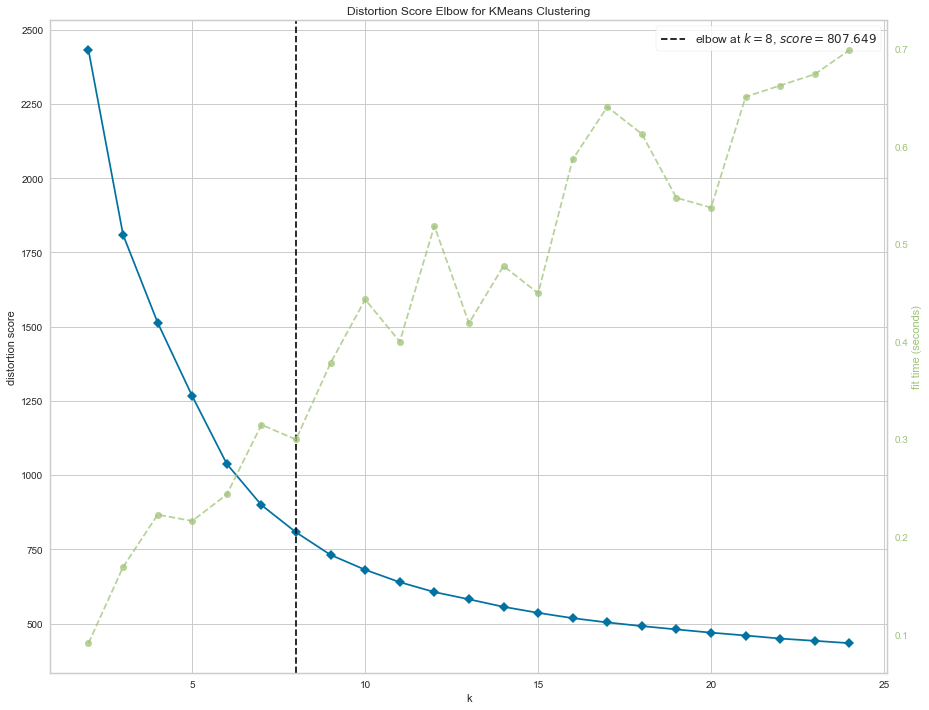

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
from sklearn.datasets import make_blobs #  generate synthetic data
# Generate synthetic dataset with 8 random clusters
# X, y = make_blobs(n_samples=1000, n_features=12, centers=11, random_state=46)

# instead use the pca broadband data
# X = low_dim_embs[ind_only[1000:13000],:2]

from yellowbrick.cluster import KElbowVisualizer # call elbow method 

X = data2[ind_only[11000:19000],:] # the range can be changed to check result consistency

# Instantiate the clustering model and visualizer
model = cluster.KMeans()
visualizer = KElbowVisualizer(model, k=(2,25))
plt.figure(1, figsize=(15,12))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

**K-Agglomerative Clustering** elbow curve

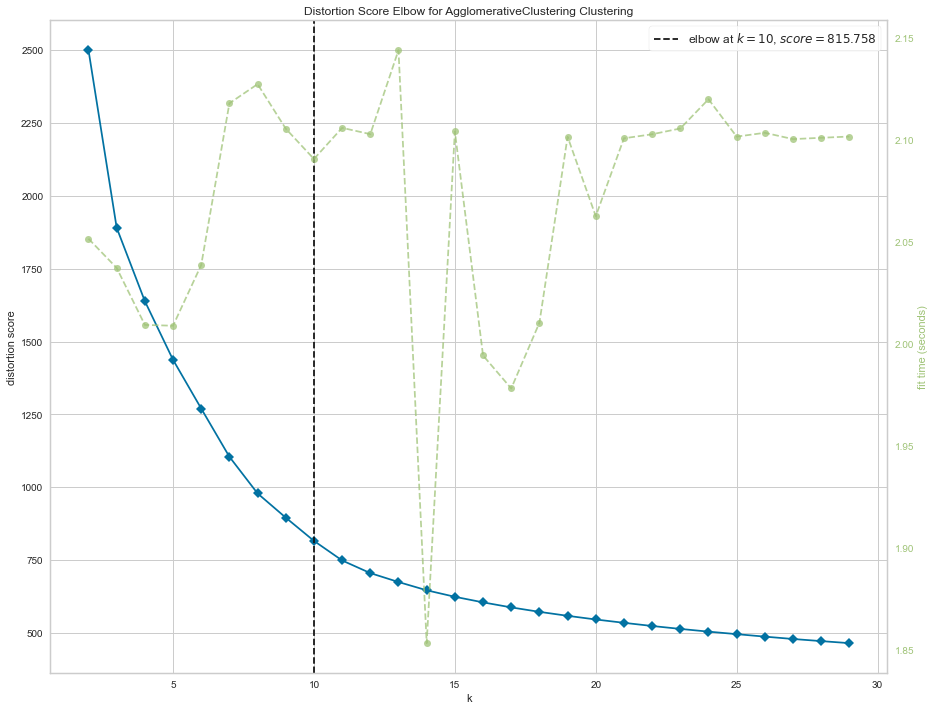

<AxesSubplot:title={'center':'Distortion Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='distortion score'>

In [16]:
# AC algorithm

X = data2[ind_only[11000:19000],:]

# Instantiate the clustering model and visualizer
model = cluster.AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,30)) # the range can be changed to check result consistency
plt.figure(1, figsize=(15,12))
visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure